In [82]:
import numpy as np
import pandas as pd
import datetime 
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from utils import *
import seaborn as sns
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 32}
plt.rc('font', **font)
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# EDA 

In [2]:
df_train = pd.read_csv("data/churn_train.csv")
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 12 columns):
avg_dist                  40000 non-null float64
avg_rating_by_driver      39838 non-null float64
avg_rating_of_driver      33472 non-null float64
avg_surge                 40000 non-null float64
city                      40000 non-null object
last_trip_date            40000 non-null object
phone                     39681 non-null object
signup_date               40000 non-null object
surge_pct                 40000 non-null float64
trips_in_first_30_days    40000 non-null int64
luxury_car_user           40000 non-null bool
weekday_pct               40000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 3.4+ MB


### 12 columns, and 3 columns have missing value, city and phone are categorical data sets

In [3]:
df_train.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct
0,6.94,5.0,5.0,1.00,Astapor,2014-05-03,Android,2014-01-12,0.0,0,False,100.0
1,8.06,5.0,5.0,1.00,Astapor,2014-01-26,Android,2014-01-25,0.0,2,True,0.0
2,21.50,4.0,NaN,1.00,Winterfell,2014-05-21,iPhone,2014-01-02,0.0,1,True,100.0
3,9.46,5.0,NaN,2.75,Winterfell,2014-01-10,Android,2014-01-09,100.0,1,False,100.0
4,13.77,5.0,NaN,1.00,Winterfell,2014-05-13,iPhone,2014-01-31,0.0,0,False,100.0


### FE 1: Conversion the signup_date to datetime object, create a churn rate features

In [4]:
df_train = pd.read_csv("data/churn_train.csv")
date1 = datetime.date(2014,06,01)
df_train["last_trip_date"] = pd.to_datetime(df_train["last_trip_date"])
df_train["signup_date"] = pd.to_datetime(df_train["signup_date"])
df_train["Churn"] = df_train["last_trip_date"] < date1

### FE 2 Dealing with missing values. 

In [5]:
df_train["phone"].unique()
df_train["phone"] = df_train["phone"].fillna("Noninfo")
df_train["phone"].unique()

array(['Android', 'iPhone', 'Noninfo'], dtype=object)

### FE3 Convert categorical column into numerial labels

In [6]:
encoder_phone = preprocessing.LabelEncoder()
encoder_city = preprocessing.LabelEncoder()
df_train["phone"] = encoder_phone.fit_transform(df_train["phone"])
df_train["city"] = encoder_city.fit_transform(df_train["city"])

### FE 4 Fillin the nan values for numerical column with the median value of each column

In [7]:
med_avg_by_drv = df_train["avg_rating_by_driver"].median()
med_avg_of_drv = df_train["avg_rating_of_driver"].median()
df_train["avg_rating_by_driver"] = df_train["avg_rating_by_driver"].fillna(med_avg_by_drv)
df_train["avg_rating_of_driver"] = df_train["avg_rating_of_driver"].fillna(med_avg_of_drv)
print(med_avg_by_drv)
print(med_avg_of_drv)

5.0
4.9


In [8]:
## Final check for  missing/Nan value anymore
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 13 columns):
avg_dist                  40000 non-null float64
avg_rating_by_driver      40000 non-null float64
avg_rating_of_driver      40000 non-null float64
avg_surge                 40000 non-null float64
city                      40000 non-null int64
last_trip_date            40000 non-null datetime64[ns]
phone                     40000 non-null int64
signup_date               40000 non-null datetime64[ns]
surge_pct                 40000 non-null float64
trips_in_first_30_days    40000 non-null int64
luxury_car_user           40000 non-null bool
weekday_pct               40000 non-null float64
Churn                     40000 non-null bool
dtypes: bool(2), datetime64[ns](2), float64(6), int64(3)
memory usage: 3.4 MB


### Summary of EDA 
### FE 1: Conversion the signup_date to datetime object, create a churn rate features
### FE 2: Dealing with missing values. 
### FE 3: Convert categorical column into numerial labels
### FE 4: Fillin the nan values for numerical column with the median value of each column
### Wrote the whole pre_processing helper functions and put in module util.py 

## Initial Model Building

In [9]:
from utils import *
df_train = pd.read_csv("data/churn_train.csv")
med_avg_by = df_train["avg_rating_by_driver"].median()
med_avg_of = df_train["avg_rating_of_driver"].median()
df_train_proc = preprocessing_df(df_train, med_avg_by_drv=med_avg_by, 
                                 med_avg_of_drv=med_avg_of)

y_train = df_train_proc["Churn"].values
X_train = df_train_proc.drop(["Churn", "signup_date","last_trip_date"],axis = 1).values
columns = df_train_proc.drop(["Churn", "signup_date","last_trip_date"],axis = 1).columns
rf = RandomForestClassifier()
scores = cross_val_score(rf, X_train, y_train, scoring="accuracy", cv=5, n_jobs=-1)
print(scores)

[ 0.73640795  0.74290714  0.7525      0.74346793  0.74134267]


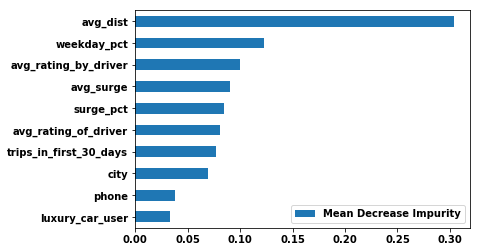

In [31]:
rf_normal = RandomForestClassifier()
rf_normal.fit(X_train,y_train)
plt.figure(figsize=(10,10))
plot_feat_importance(rf_normal.feature_importances_,columns)

## Good example of data leakage
###  Created a feature user age, which is the time difference between sign up date and churn date, which leak the churn information into this predictor

[ 0.95463067  0.95538058  0.954875    0.9559945   0.95299412]


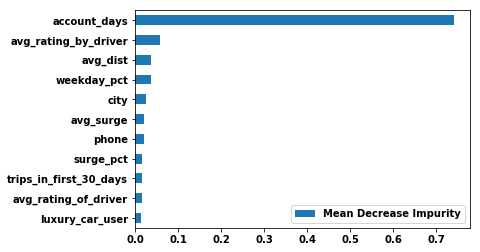

In [32]:
# FE Account Days, Data Leakage Found
df_train = pd.read_csv("data/churn_train.csv")
med_avg_by = df_train["avg_rating_by_driver"].median()
med_avg_of = df_train["avg_rating_of_driver"].median()
df_train_proc_l = preprocessing_df(df_train, med_avg_by_drv=med_avg_by, 
                                 med_avg_of_drv=med_avg_of)

diff = datetime.timedelta()
df_train_proc_l['age_delta'] = df_train_proc_l['last_trip_date'] - df_train_proc_l['signup_date']
df_train_proc_l["account_days"] = df_train_proc_l["age_delta"].apply(lambda x: x.days)
df_train_proc_l.drop("age_delta", axis=1, inplace=True)

y_train_l = df_train_proc_l["Churn"].values
X_train_l = df_train_proc_l.drop(["Churn", "signup_date","last_trip_date"],axis = 1).values
columns_l = df_train_proc_l.drop(["Churn", "signup_date","last_trip_date"],axis = 1).columns
rf = RandomForestClassifier()
scores = cross_val_score(rf, X_train_l, y_train_l, scoring="accuracy", cv=5, n_jobs=-1)
print(scores)

rf_leak = RandomForestClassifier()
rf_leak.fit(X_train_l,y_train_l)
plt.figure(figsize=(10,10))
plot_feat_importance(rf_leak.feature_importances_,columns_l)
# df_train_proc_l["signup_date"].hist()
# df_train_proc_l["last_trip_date"].hist()

## Model Optimizations

In [12]:
## Grid Search For Random Forest
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
rf_parameters = {'n_estimators': [50,100,200], 
                 'max_features': ['sqrt'], 
                 'max_depth': [13]}
gs = GridSearchCV(RandomForestClassifier(), rf_parameters, scoring="accuracy", n_jobs = -1, cv = 5)
gs.fit(X_train, y_train)
print("Best Parameters : ",gs.best_params_)
print("Best Accruacy :", gs.best_score_)

('Best Parameters : ', {'max_features': 'sqrt', 'n_estimators': 100, 'max_depth': 13})
('Best Accruacy :', 0.78407499999999997)


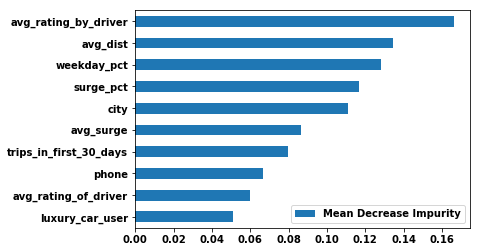

In [33]:
## Training using the best model parameters and explore feature importance
df_train = pd.read_csv("data/churn_train.csv")
med_avg_by = df_train["avg_rating_by_driver"].median()
med_avg_of = df_train["avg_rating_of_driver"].median()
df_train_proc = preprocessing_df(df_train, med_avg_by_drv=med_avg_by, 
                                 med_avg_of_drv=med_avg_of)

y_train = df_train_proc["Churn"].values
X_train = df_train_proc.drop(["Churn", "signup_date","last_trip_date"],axis = 1).values


columns = df_train_proc.drop(["Churn", "signup_date","last_trip_date"],axis = 1).columns
rf_best = RandomForestClassifier(n_estimators=100, max_features="sqrt", max_depth=13)
rf_best.fit(X_train,y_train)
plot_feat_importance(rf_best.feature_importances_,columns)

[ 1.   1.5  2.   2.3  2.5  2.7  2.8  3.   3.2  3.3  3.4  3.5  3.6  3.7  3.8
  3.9  4.   4.1  4.2  4.3  4.4  4.5  4.6  4.7  4.8  4.9  5. ]


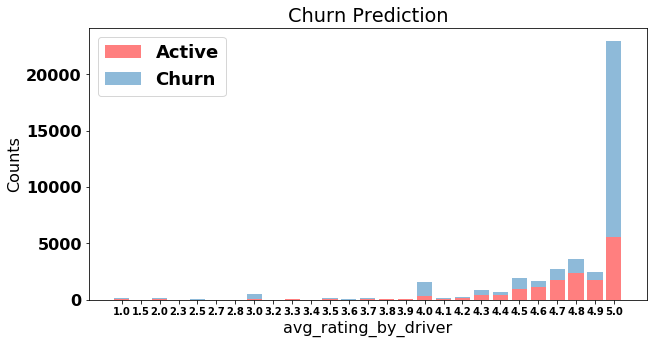

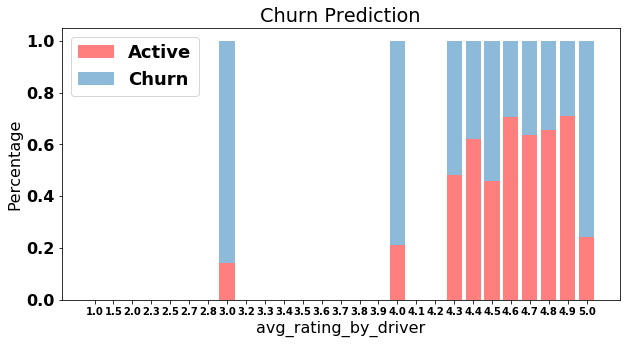

In [49]:
def bar_plot_feature(df, column_name, target = "Churn"):
    '''
    df: dataframe 
    column_name: the feature for x axis
    target: Churn 
    '''
    column_unique = np.sort(df[column_name].unique())
    print(column_unique)
    target_unique = df[target].unique()
    group_count = {}
    for target_uniq_i in target_unique:
        group_count[target_uniq_i] = []
        for column_i in column_unique:
            group_count[target_uniq_i].append(np.sum((df[target] == target_uniq_i) 
                                                     & (df[column_name] == column_i)))
        group_count[target_uniq_i] = np.array(group_count[target_uniq_i])
        
    x_pos = np.arange(len(column_unique))
    
    plt.rcParams.update({'font.size': 16})
    plt.rc('xtick', labelsize=10) 
    plt.figure(figsize = (10,5))
    plt.bar(x_pos, group_count[False], align='center', alpha=0.5, color = "r", label = "Active")
    plt.bar(x_pos, group_count[True], align='center', alpha=0.5, bottom=group_count[False], label="Churn")
    plt.xticks(x_pos, column_unique)
    plt.xlabel(column_name)
    plt.ylabel('Counts')
    plt.title("Churn Prediction")
    plt.legend(prop={'size': 18})
    plt.show()
    
    plt.figure(figsize = (10,5))
    total = (group_count[False] + group_count[True]).astype("float")
    False_ratio = group_count[False]/total
    True_ratio = group_count[True]/total
    False_ratio[total < 300] = 0
    True_ratio[total < 300] = 0
    plt.bar(x_pos, False_ratio, align='center', alpha=0.5, color = "r", label = "Active")
    plt.bar(x_pos, True_ratio, align='center', alpha=0.5, bottom=False_ratio, label="Churn")
    plt.xticks(x_pos, column_unique)
    plt.xlabel(column_name)
    plt.ylabel('Percentage')
    plt.title("Churn Prediction")
    plt.legend(prop={'size': 18})
    plt.show()
bar_plot_feature(df_train_proc, column_name="avg_rating_by_driver")

(-2, 30)

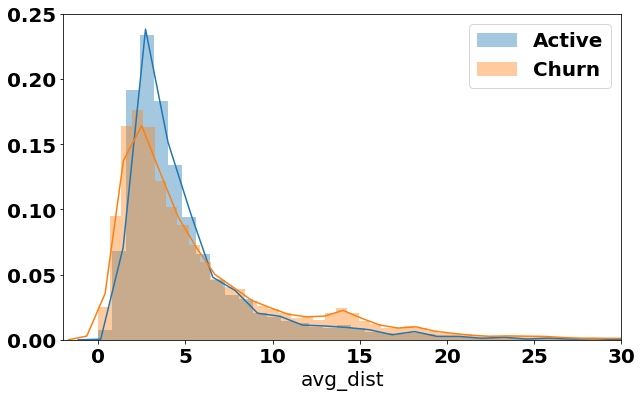

In [63]:
Churn_df = df_train_proc[df_train_proc["Churn"] == True]
Active_df = df_train_proc[df_train_proc["Churn"] == False]
plt.figure(figsize = (10,6))
plt.rcParams.update({'font.size': 20})
plt.rc('xtick', labelsize=20) 
sns.distplot(Active_df["avg_dist"],bins = 200, norm_hist=True, label = "Active")
sns.distplot(Churn_df["avg_dist"], bins = 200, norm_hist=True, label = "Churn")
plt.legend()
plt.xlim(-2,30)

In [64]:
## Best Model 
from sklearn.model_selection import cross_val_score
df_train = pd.read_csv("data/churn_train.csv")
med_avg_by = df_train["avg_rating_by_driver"].median()
med_avg_of = df_train["avg_rating_of_driver"].median()
df_train_proc = preprocessing_df(df_train, med_avg_by_drv=med_avg_by, 
                                 med_avg_of_drv=med_avg_of)

y_train = df_train_proc["Churn"].values
X_train = df_train_proc.drop(["Churn", "signup_date","last_trip_date"],axis = 1).values
rf_best = RandomForestClassifier(n_estimators=100, max_features="sqrt", max_depth=13)
print(cross_val_score(rf_best,X_train,y_train,cv=5))

[ 0.7847769   0.78290214  0.78825     0.78484811  0.77859732]


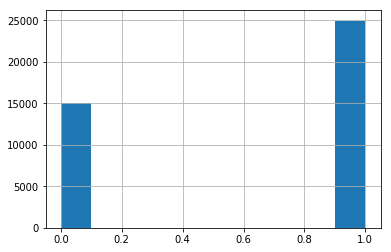

In [28]:
df_train_proc["Churn"].hist()

In [66]:
# Business Value
## We have a churn prediction model, that predict the churn rate of a customer with 79% accuracy
## When we predict a customer churn, we are going to send out a 10$ coupon, and assume 90% of them stays. 
## Based on this the cost_benefit matrix is 
cost_benefit = [[-20,-10],[-100,0]]

In [81]:
## Final Model and make prediciton on Test data Sets
df_train = pd.read_csv("data/churn_train.csv")
med_avg_by = df_train["avg_rating_by_driver"].median()
med_avg_of = df_train["avg_rating_of_driver"].median()
df_train_proc = preprocessing_df(df_train, med_avg_by_drv=med_avg_by, 
                                 med_avg_of_drv=med_avg_of)
y_train = df_train_proc["Churn"].values
X_train = df_train_proc.drop(["Churn", "signup_date","last_trip_date"],axis = 1).values
columns = df_train_proc.drop(["Churn", "signup_date","last_trip_date"],axis = 1).columns

df_test = pd.read_csv("data/churn_test.csv")
df_test_proc = preprocessing_df(df_test, med_avg_by_drv=med_avg_by, 
                                 med_avg_of_drv=med_avg_of)

y_test = df_test_proc["Churn"].values
X_test= df_test_proc.drop(["Churn", "signup_date","last_trip_date"],axis = 1).values


rf_best = RandomForestClassifier(n_estimators=100, max_features="sqrt", max_depth=13)
rf_best.fit(X_train,y_train)
y_best_pred = rf_best.predict(X_test)
print("Accurancy optimized for best Accuracy is", accuracy_score(y_best_pred,y_test))
conf_best = standard_confusion_matrix(y_best_pred,y_test)
print("Confusion Matrix is ",conf_best)
profit = conf_best * cost_benefit / np.sum(conf_best)
print("Profit is ", profit)
print("Precision is ", precision_score(y_best_pred, y_test))
print("Recall is ", recall_score(y_best_pred, y_test))

('Accurancy optimized for best Accuracy is', 0.77680000000000005)
('Confusion Matrix is ', array([[5318,  910],
       [1322, 2450]]))
('Profit is ', array([[-11,  -1],
       [-14,   0]]))
('Precision is ', 0.85388567758509959)
('Recall is ', 0.80090361445783131)


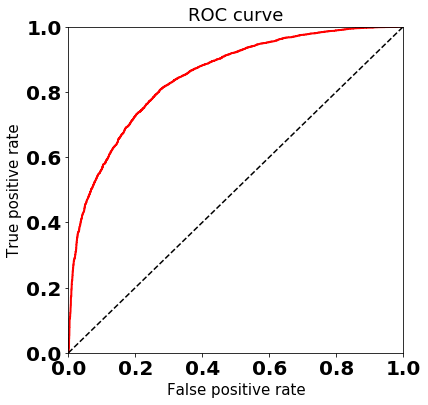

In [84]:
fpr, tpr, thresholds = roc_curve(y_test, rf_best.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)
fig = plt.figure(figsize=(6,6))
plt.rcParams.update({'font.size': 20})
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
ax = fig.add_subplot(1,1,1)
ax.plot(fpr, tpr, lw=2, c='r')
ax.plot([0 ,1], [0, 1], 'k--')
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_xlabel('False positive rate', fontsize = 15)
ax.set_ylabel('True positive rate', fontsize = 15)
ax.set_title('ROC curve', fontsize = 18)
plt.show()

In [76]:
## Currrent Churn rate is 62.4%
## If one customer churns, the company lose $100 in CLTV revenue 
## Assume the company has 10,000 customer
n_customer = 10000
print("Current Churn Rate is",np.mean(df_train_proc["Churn"]) )
print("Current company is losing $ %f due to customer Churn"%(n_customer * (-100) * 0.624))

('Current Churn Rate is', 0.62419999999999998)
Current company is losing $ -624000.000000 due to customer Churn


In [41]:
## We have a churn prediction model, that predict the churn rate of a customer with 79% accuracy
## When we predict a customer churn, we are going to send out a 10$ coupon, and 90% of them stays. 
## Based on this the cost_benefit matrix is 
cost_benefit = [[-20,-10],[-100,0]]
Expected_profit = -23
Expected_profit_total = n_customer * Expected_profit
print("When the model prediction and the promotion action, the profit is ", Expected_profit_total)

('When the model prediction and the promotion action, the profit is ', -230000)


In [42]:
Total_diff = Expected_profit_total - n_customer * (-100) * 0.624
print("The total $ different the model makes is ", Total_diff)

('The total $ different the model makes is ', 394000.0)


# Conclusion: 
## For EDA and Feature Engineering
### FE 1: Conversion the signup_date to datetime object, create a churn rate features
### FE 2: Dealing with missing values. 
### FE 3: Convert categorical column into numerial labels
### FE 4: Fillin the nan values for numerical column with the median value of each
## For Model Building
### Selected Random Forest Classifier 
### Best parameters n_estimator = 100, max_feature = "sqrt", max_depth = 13
### Accuracy 0.779, Precision 0.85, Recall 0.80
### Feature importance: Avg_dist,  rating_by_driver. 
## Business Value
### Assume the total number of user is 10,000
### We have a churn prediction model, that predict the churn rate of a customer with 79% accuracy. When we predict a customer churn, we are going to send out a 10 dollar coupon, and 90% of them stays. 
###  The total revenue this prediciton model is expected to bring is 394,000 dollars
## Recommendation 
### Based on feature analysis, we recommend to encourage driver engagement. The more detail the drive rating the rider, the lower the churn rate. 
### Send promotion to users who has average distance between 2 ~ 7 miles
### Based on prediction model, when we predict a user has a high chance of churning, we send out a promotion coupon to keep them. 